# Project Histology Tissue Classification Project - Data exploration

## TA.BA_IN_SYS_MM.H2201 (HSLU)

Author: Umberto Michelucci (umberto.michelucci@hslu.ch)

The goal of this notebook is to first look at the data we have at our disposal. Check which classes we have, if we have unbalanced classes, missing values and so on. This is always the first step in any machine learning project.

## Import needed packages

Note that you will need to install some packages in case you do not have them already.

In [3]:
import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from glob import glob
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle
import cv2

We can check the TensorFlow version we have, altough we do not need much TensorFlow yet. 
In Python is easy to check the version of each package: just use ```<PACKAGE_NAME>.__version__```

In [4]:
tf.__version__

'2.7.0'

## Data exploration
### Helper function for Pandas

This is a function that you can safely ignore. It simply set some parameters for ```pandas``` to make visualisation of the results easier and more readable.

In [5]:
def pandas_display():
    """
    Function to setup pandas parameters for interactive session for better display of the DataFrame.

    Returns
    -------
    None
    """

    options = {
        'display': {
            'max_columns': 550,
            'width': 3000,
            'max_colwidth': -1,
            'expand_frame_repr': False,  # Don't wrap to multiple pages
            'max_rows': 200,
            'max_seq_items': 50,         # Max length of printed sequence
            'precision': 4,
            'show_dimensions': False
        },
        'mode': {
            'chained_assignment': None   # Controls SettingWithCopyWarning
        }
    }

    for category, option in options.items():
        for op, value in option.items():
            print('{}.{}'.format(category, op), value)
            pd.set_option('{}.{}'.format(category, op), value)

In [6]:
pandas_display()

display.max_columns 550
display.width 3000
display.max_colwidth -1
display.expand_frame_repr False
display.max_rows 200
display.max_seq_items 50
display.precision 4
display.show_dimensions False
mode.chained_assignment None


/Users/umberto/Python-Environments/tf25/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


### Data extraction

Now we need to extract the data from the folder. Each image is in a different folder so we need to go through them and load each image separately. Additionally we need to extract information from the folder name and the file name.

In [7]:
base_dir = '../data/kather_texture_2016_image_tiles_5000'

In [8]:
df = pd.DataFrame({'path': glob(os.path.join(base_dir, '*', '*.tif'))})

In [9]:
df.shape

(5000, 1)

In [71]:
df.head()

path
0  ../data/kather_texture_2016_image_tiles_5000/02_STROMA/14389_CRC-Prim-HE-07_026.tif_Row_751_Col_151.tif  
1  ../data/kather_texture_2016_image_tiles_5000/02_STROMA/1163A_CRC-Prim-HE-05_009b.tif_Row_751_Col_1201.tif
2  ../data/kather_texture_2016_image_tiles_5000/02_STROMA/118E_CRC-Prim-HE-02_015.tif_Row_301_Col_3601.tif  
3  ../data/kather_texture_2016_image_tiles_5000/02_STROMA/12238_CRC-Prim-HE-09.tif_Row_151_Col_2551.tif     
4  ../data/kather_texture_2016_image_tiles_5000/02_STROMA/100A6_CRC-Prim-HE-02_029.tif_Row_601_Col_301.tif

As you can see the class (for example ```STROMA```) is contained in the folder and must be extracted to be able to create a dataset.

In [10]:
df['file_id'] = df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
df['cell_type'] = df['path'].map(lambda x: os.path.basename(os.path.dirname(x))) 
df['cell_type_idx'] = df['cell_type'].map(lambda x: int(x.split('_')[0]))
df['cell_type'] = df['cell_type'].map(lambda x: x.split('_')[1])
df['full_image_name'] = df['file_id'].map(lambda x: x.split('_Row')[0])
df['full_image_row'] = df['file_id'].map(lambda x: int(x.split('_')[-3]))
df['full_image_col'] = df['file_id'].map(lambda x: int(x.split('_')[-1]))

The previous cell, gets information from the path or the name and create new columns in the pandas dataframe with the right information. For example the line

    df['path'].map(lambda x: os.path.basename(os.path.dirname(x))) 

extract the cell type. Note that the steps are coming one after the other. In fact to get the ```'cell_type'``` two steps are required (check above).

In [11]:
df.head()

path                                         file_id cell_type  cell_type_idx                full_image_name  full_image_row  full_image_col
0  ../data/kather_texture_2016_image_tiles_5000/02_STROMA/14389_CRC-Prim-HE-07_026.tif_Row_751_Col_151.tif    14389_CRC-Prim-HE-07_026.tif_Row_751_Col_151    STROMA    2              14389_CRC-Prim-HE-07_026.tif   751             151           
1  ../data/kather_texture_2016_image_tiles_5000/02_STROMA/1163A_CRC-Prim-HE-05_009b.tif_Row_751_Col_1201.tif  1163A_CRC-Prim-HE-05_009b.tif_Row_751_Col_1201  STROMA    2              1163A_CRC-Prim-HE-05_009b.tif  751             1201          
2  ../data/kather_texture_2016_image_tiles_5000/02_STROMA/118E_CRC-Prim-HE-02_015.tif_Row_301_Col_3601.tif    118E_CRC-Prim-HE-02_015.tif_Row_301_Col_3601    STROMA    2              118E_CRC-Prim-HE-02_015.tif    301             3601          
3  ../data/kather_texture_2016_image_tiles_5000/02_STROMA/12238_CRC-Prim-HE-09.tif_Row_151_Col_2551.tif       12238_CRC-Prim-HE-09.tif_Row_151_Col_2551       STROMA    2              12238_CRC-Prim-HE-09.tif       151             2551          
4  ../data/kather_texture_2016_image_tiles_5000/02_STROMA/100A6_CRC-Prim-HE-02_029.tif_Row_601_Col_301.tif    100A6_CRC-Prim-HE-02_029.tif_Row_601_Col_301    STROMA    2              100A6_CRC-Prim-HE-02_029.tif   601             301

The following cell reads the images from the hard disk and save them in a column in the pandas dataframe.

In [12]:
df['image'] = df['path'].map(imread)

In [14]:
df.head(1)

path                                       file_id cell_type  cell_type_idx               full_image_name  full_image_row  full_image_col                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

## Serialising the dataframe (saving it in binary format)

The next step is not mandatory. You can save the dataframe (that is already prepared) in [```pickle```](https://docs.python.org/3/library/pickle.html) format. This is a binary format that can be read directly again in python and that contains all the columns and rows exactly as you prepared them. In this way you do not need to re-do all the data preparation again.

The pickle module implements binary protocols for serializing and de-serializing a Python object structure. “Pickling” is the process whereby a Python object hierarchy is converted into a byte stream, and “unpickling” is the inverse operation, whereby a byte stream (from a binary file or bytes-like object) is converted back into an object hierarchy. Pickling (and unpickling) is alternatively known as “serialization”, “marshalling,” or “flattening”; however, to avoid confusion, the terms used here are “pickling” and “unpickling” (from the [Officiel pickle documentation](https://docs.python.org/3/library/pickle.html#id7)).

In [77]:
# The code is commented out since the file is ca. 380 Mb. You do not need to save it if you do not want to.

#df.to_pickle('../data/dataframe_Kather_texture_2016_image_tiles_5000.pkl')

The following cell is here as a reference. If you have saved the data as ```pickle``` you can then re-load them from the pkl file with the following command. It is quite useful.

In [ ]:
#df=pd.read_pickle('./data/dataframe_Kather_texture_2016_image_tiles_5000.pkl')

## Checking missing values

One of the first thing to do in any machine learning project is to check if missing values are present.

In [13]:
df.isnull().sum()

path               0
file_id            0
cell_type          0
cell_type_idx      0
full_image_name    0
full_image_row     0
full_image_col     0
image              0
dtype: int64

Now we need to check which are the classes that are present. Since in the data frame ```df``` we have the class, we can simply check what are the unique values. In pandas you can use the ```unique()``` call.

In [14]:
df['cell_type'].unique()

array(['STROMA', 'MUCOSA', 'DEBRIS', 'TUMOR', 'COMPLEX', 'EMPTY',
       'LYMPHO', 'ADIPOSE'], dtype=object)

Just out of curiosity, we can also check how much memory the dataset needs. Pandas has a very useful function called 

In [15]:
df.memory_usage(deep=True).sum()/1024**2

324.6067705154419

In [78]:
 df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   path             5000 non-null   object
 1   file_id          5000 non-null   object
 2   cell_type        5000 non-null   object
 3   cell_type_idx    5000 non-null   int64 
 4   full_image_name  5000 non-null   object
 5   full_image_row   5000 non-null   int64 
 6   full_image_col   5000 non-null   int64 
 7   image            5000 non-null   object
dtypes: int64(3), object(5)
memory usage: 324.6 MB


In [89]:
# This is how the first record in the dataset looks like...
df.head(1)

path                                       file_id cell_type  cell_type_idx               full_image_name  full_image_row  full_image_col                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [82]:
len(df), len(df.columns)

(5000, 8)

In [83]:
df.shape

(5000, 8)

The dataset has 5000 images saved in the ```image``` column. What resolution and size have the images? We can quickly check it.

In [86]:
df['image'][0].shape

(150, 150, 3)

### Checking if we have imbalanced classes

In [87]:
df['cell_type'].value_counts()

STROMA     625
MUCOSA     625
DEBRIS     625
TUMOR      625
COMPLEX    625
EMPTY      625
LYMPHO     625
ADIPOSE    625
Name: cell_type, dtype: int64

### Checking duplicates

We have not checked if there are files that appear multiple times. 

In [88]:
df['full_image_name'][df.duplicated('full_image_name')]

3542    140E1_CRC-Prim-HE-06_005.tif
3665    1411C_CRC-Prim-HE-06_005.tif
3742    14AD7_CRC-Prim-HE-06_005.tif
4229    15EA0_CRC-Prim-HE-01_013.tif
4972    16193_CRC-Prim-HE-05_032.tif
Name: full_image_name, dtype: object

In [21]:
df[df['full_image_name'] == '140E1_CRC-Prim-HE-06_005.tif']['full_image_name']

3145    140E1_CRC-Prim-HE-06_005.tif
3542    140E1_CRC-Prim-HE-06_005.tif
Name: full_image_name, dtype: object

In [22]:
df['full_image_name'][df['full_image_name'].duplicated()].index

Int64Index([3542, 3665, 3742, 4229, 4972], dtype='int64')

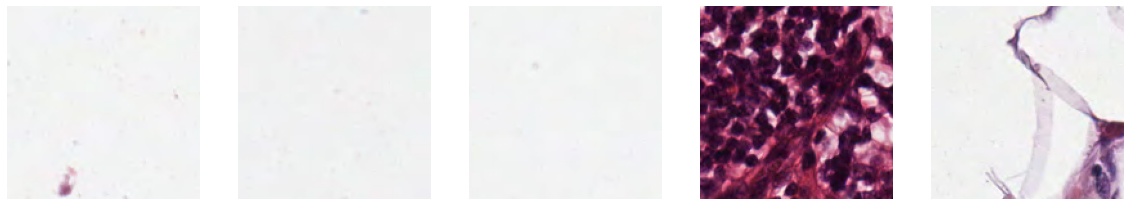

In [23]:
n_samples = 5
fig, m_axs = plt.subplots(1, n_samples, figsize = (4*n_samples, 3*8))

for n_axs, idx in zip(m_axs, df['full_image_name'][df['full_image_name'].duplicated()].index):
    n_axs.imshow(df.iloc[int(idx)]['image'])
    n_axs.axis('off')

## Data visualization of some examples

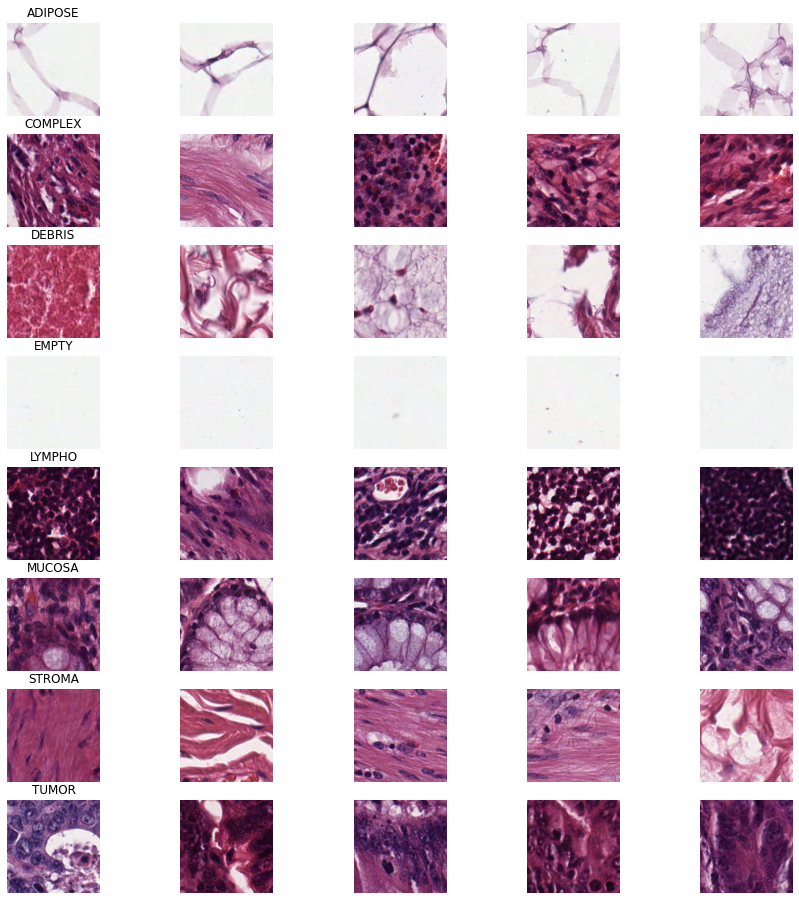

In [24]:
n_samples = 5
fig, m_axs = plt.subplots(8, n_samples, figsize = (3*n_samples, 2*8))

for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name, loc='center')
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [25]:
df['image'][0].shape

(150, 150, 3)

In [26]:
df['image'][0].dtype

dtype('uint8')

## Reshuffling of the data

In [27]:
df[['path', 'file_id', 'cell_type', 'cell_type_idx', 'full_image_name', 'full_image_row', 'full_image_col']].head(5)

path                                         file_id cell_type  cell_type_idx                full_image_name  full_image_row  full_image_col
0  ../data/kather_texture_2016_image_tiles_5000/02_STROMA/14389_CRC-Prim-HE-07_026.tif_Row_751_Col_151.tif    14389_CRC-Prim-HE-07_026.tif_Row_751_Col_151    STROMA    2              14389_CRC-Prim-HE-07_026.tif   751             151           
1  ../data/kather_texture_2016_image_tiles_5000/02_STROMA/1163A_CRC-Prim-HE-05_009b.tif_Row_751_Col_1201.tif  1163A_CRC-Prim-HE-05_009b.tif_Row_751_Col_1201  STROMA    2              1163A_CRC-Prim-HE-05_009b.tif  751             1201          
2  ../data/kather_texture_2016_image_tiles_5000/02_STROMA/118E_CRC-Prim-HE-02_015.tif_Row_301_Col_3601.tif    118E_CRC-Prim-HE-02_015.tif_Row_301_Col_3601    STROMA    2              118E_CRC-Prim-HE-02_015.tif    301             3601          
3  ../data/kather_texture_2016_image_tiles_5000/02_STROMA/12238_CRC-Prim-HE-09.tif_Row_151_Col_2551.tif       12238_CRC-Prim-HE-09.tif_Row_151_Col_2551       STROMA    2              12238_CRC-Prim-HE-09.tif       151             2551          
4  ../data/kather_texture_2016_image_tiles_5000/02_STROMA/100A6_CRC-Prim-HE-02_029.tif_Row_601_Col_301.tif    100A6_CRC-Prim-HE-02_029.tif_Row_601_Col_301    STROMA    2              100A6_CRC-Prim-HE-02_029.tif   601             301

We can easily check that the images are not shuffled by simply checking the index distributions.

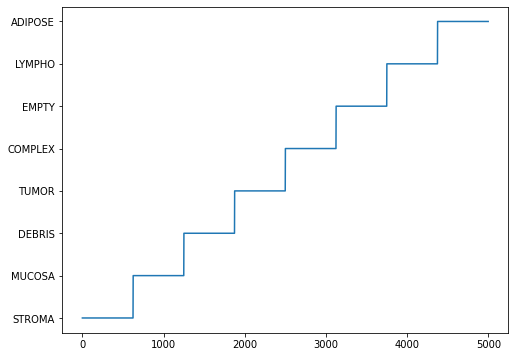

In [29]:
plt.figure(figsize=(8,6))
plt.plot(df.index.values, df['cell_type'])
plt.show()

In [30]:
max(df.index.values), min(df.index.values)

(4999, 0)

In [31]:
import random
rows = df.index.values
random.shuffle(rows)
rows

array([3635, 1924, 3240, ...,  176, 4421,  386])

In [32]:
max(rows), min(rows)

(4999, 0)

In [33]:
df=df.reindex(rows)
df.sort_index(inplace=True)

Now the indexes are not ordered anymore as it is easy to see from the image.

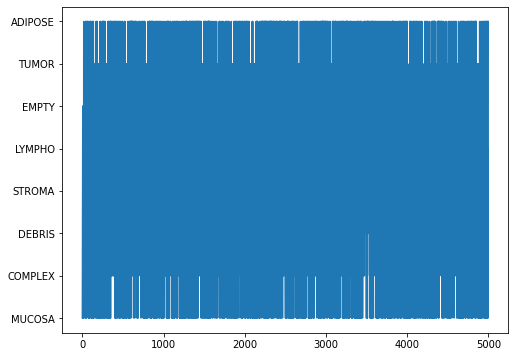

In [34]:
plt.figure(figsize=(8,6))
plt.plot(df.index.values, df['cell_type'])
plt.show()

## Preparing the features and the labels
### One hot encoding of the labels

In [35]:
df_label = pd.get_dummies(df['cell_type'])

In [36]:
df_label.head()

ADIPOSE  COMPLEX  DEBRIS  EMPTY  LYMPHO  MUCOSA  STROMA  TUMOR
0  0        0        0       0      0       1       0       0    
1  0        1        0       0      0       0       0       0    
2  0        0        1       0      0       0       0       0    
3  0        0        0       0      0       0       1       0    
4  0        0        0       0      1       0       0       0

In [37]:
dict_label=list(df_label.columns)
dict_label

['ADIPOSE',
 'COMPLEX',
 'DEBRIS',
 'EMPTY',
 'LYMPHO',
 'MUCOSA',
 'STROMA',
 'TUMOR']

In [38]:
label=df_label.values

In [39]:
label.shape, label.dtype

((5000, 8), dtype('uint8'))

In [40]:
label

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

### Selection of the features: pixels of the images

We need to reshape the images to be able to use them with Keras.

In [41]:
data=np.array(df['image'].tolist())

In [42]:
data.shape, data.dtype

((5000, 150, 150, 3), dtype('uint8'))

## Split Training/Validation/Testing datasets

### Split for Training/Validation/Testing

In [43]:
x, x_test, y, y_test = train_test_split(data, label, test_size=0.2,train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.25,train_size =0.75)

In [44]:
print('1- Training set:', x_train.shape, y_train.shape)
print('2- Validation set:', x_val.shape, y_val.shape)
print('3- Testing set:', x_test.shape, y_test.shape)

1- Training set: (3000, 150, 150, 3) (3000, 8)
2- Validation set: (1000, 150, 150, 3) (1000, 8)
3- Testing set: (1000, 150, 150, 3) (1000, 8)


### Cast of the input pixels

In [45]:
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
x_val = np.array( x_val, dtype=np.float32)

We can easily check that the max and the min of the pixel values are 255 and 0 respectively.

In [46]:
np.amax(x_train), np.amax(x_test), np.amax(x_val)

(255.0, 255.0, 255.0)

In [47]:
np.amin(x_train), np.amin(x_test), np.amin(x_val)

(0.0, 0.0, 0.0)

### Normalization of the input pixels in the 3 channels

In [48]:
x_train /= 255.0
x_test /= 255.0
x_val /= 255.0

In [49]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('x_val shape:', x_val.shape)

x_train shape: (3000, 150, 150, 3)
x_test shape: (1000, 150, 150, 3)
x_val shape: (1000, 150, 150, 3)


### Saving the data as pickle files

In [ ]:
pickle.dump(x_train, open('./data/x_train.pkl', 'wb'))
pickle.dump(x_test, open('./data/x_test.pkl', 'wb'))
pickle.dump(x_val, open('./data/x_val.pkl', 'wb'))

In [ ]:
pickle.dump(y_train, open('./data/y_train.pkl', 'wb'))
pickle.dump(y_test, open('./data/y_test.pkl', 'wb'))
pickle.dump(y_val, open('./data/y_val.pkl', 'wb'))

## Data analyses
### Data distributions

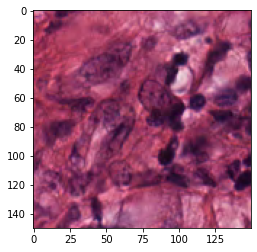

In [50]:
plt.imshow(df['image'][1]);

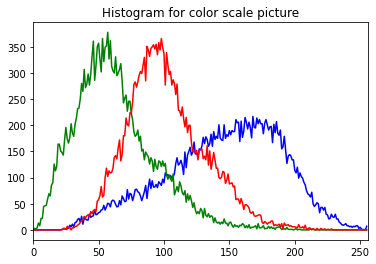

In [51]:
img=df['image'][1]
color = ('b','g','r')
for channel,col in enumerate(color):
    histr = cv2.calcHist([img],[channel],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.title('Histogram for color scale picture')
plt.show()

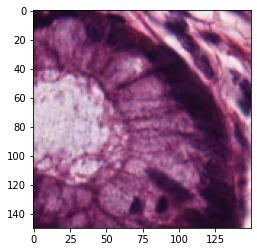

In [52]:
plt.imshow(df['image'][10]);

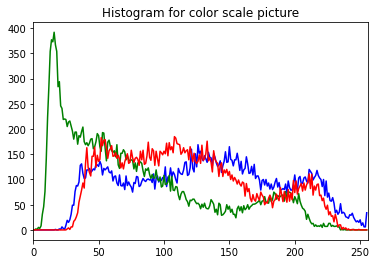

In [53]:
img=df['image'][10]
color = ('b','g','r')
for channel,col in enumerate(color):
    histr = cv2.calcHist([img],[channel],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.title('Histogram for color scale picture')
plt.show()

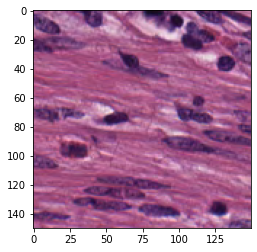

In [54]:
plt.imshow(df['image'][308]);

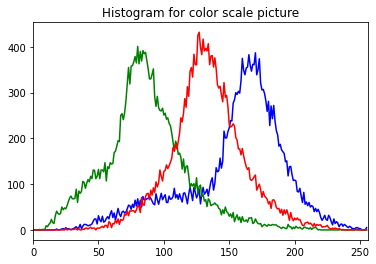

In [55]:
img=df['image'][308]
color = ('b','g','r')
for channel,col in enumerate(color):
    histr = cv2.calcHist([img],[channel],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.title('Histogram for color scale picture')
plt.show()

### Histogram Equalization
Look at three image augmentation techniques for improving contrast in images

In [56]:
# Import skimage modules
from skimage import data, img_as_float
from skimage import exposure

# Lets try augmenting a cifar10 image using these techniques
from skimage import data, img_as_float
from skimage import exposure

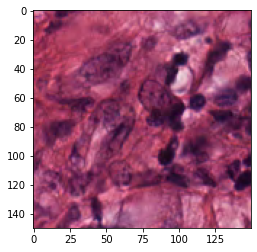

In [57]:
plt.imshow(df['image'][1]);

In [58]:
def plot_img_and_hist(img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    img = img_as_float(img)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(img.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


/Users/umberto/Python-Environments/tf25/lib/python3.7/site-packages/skimage/_shared/utils.py:338: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)
/Users/umberto/Python-Environments/tf25/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
/Users/umberto/Python-Environments/tf25/lib/python3.7/site-packages/skimage/_shared/utils.py:338: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channe

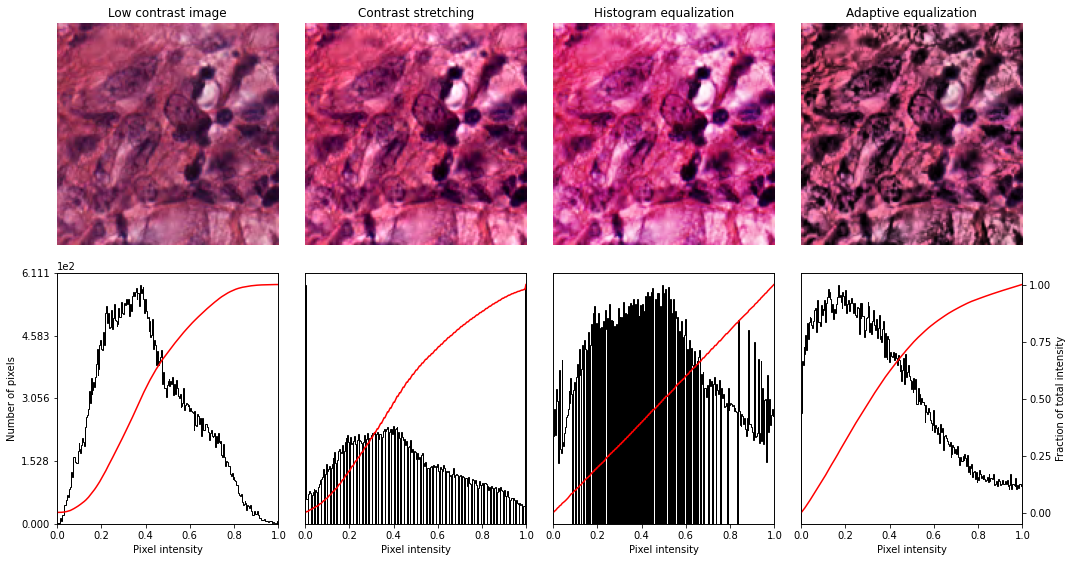

In [59]:
# choose an image
img=df['image'][1]

# contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# histogram Equalization
img_eq = exposure.equalize_hist(img)

# ddaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# display results
fig = plt.figure(figsize=(15, 8)) 
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)
    
ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

## Data augmentation

In [60]:
from keras_preprocessing.image import ImageDataGenerator

### Shift images vertically or horizontally by 20%

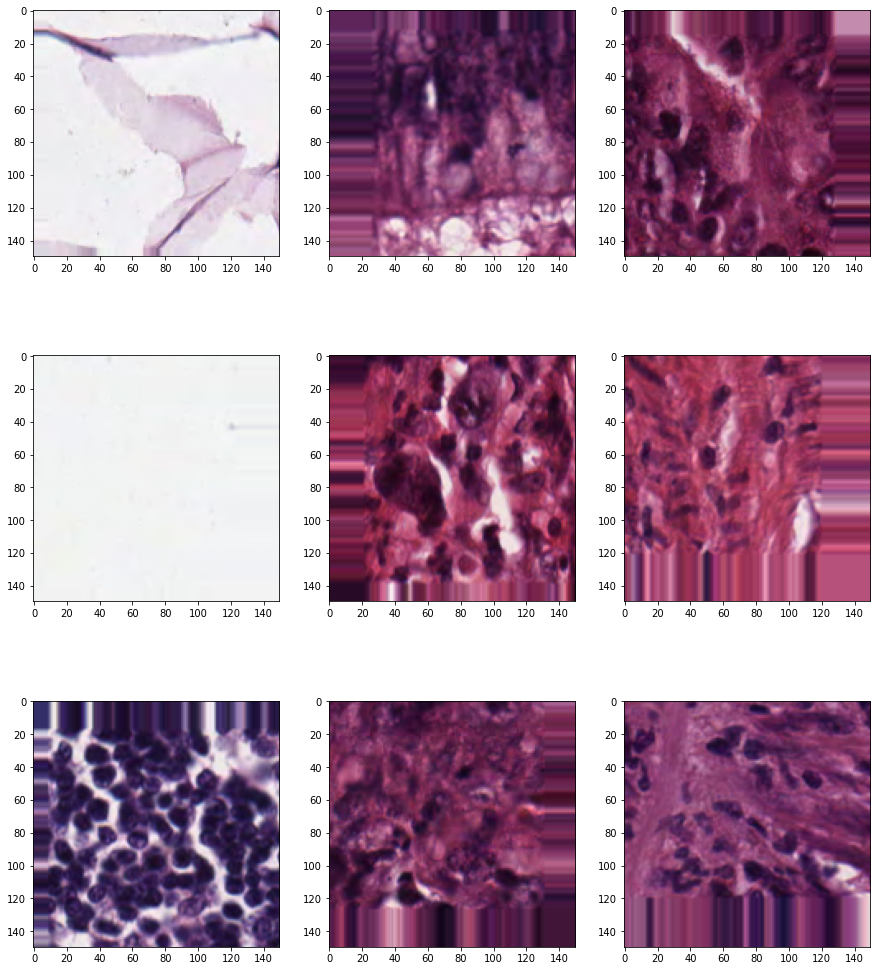

In [61]:
# fill missing pixels with the color of the nearest pixel
datagen = ImageDataGenerator(width_shift_range=.2, 
                             height_shift_range=.2,
                             fill_mode='nearest')

# fit parameters from data
datagen.fit(x_train)

# Configure batch size and retrieve one batch of images
plt.subplots(3, 3, figsize = (15, 18))             
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    # show the plot
    plt.show()
    break

### Flip images vertically

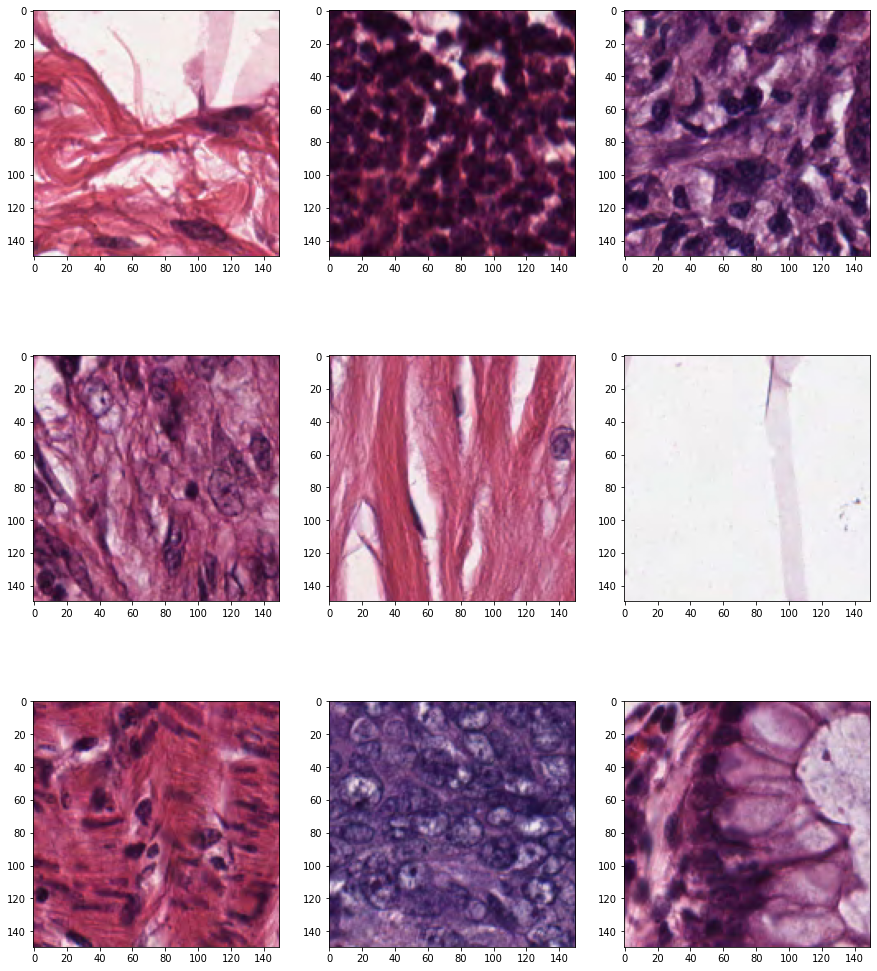

In [62]:
datagen = ImageDataGenerator(vertical_flip=True)

# fit parameters from data
datagen.fit(x_train)

# Configure batch size and retrieve one batch of images
plt.subplots(3, 3, figsize = (15, 18))             
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    # show the plot
    plt.show()
    break

### Randomly rotate images

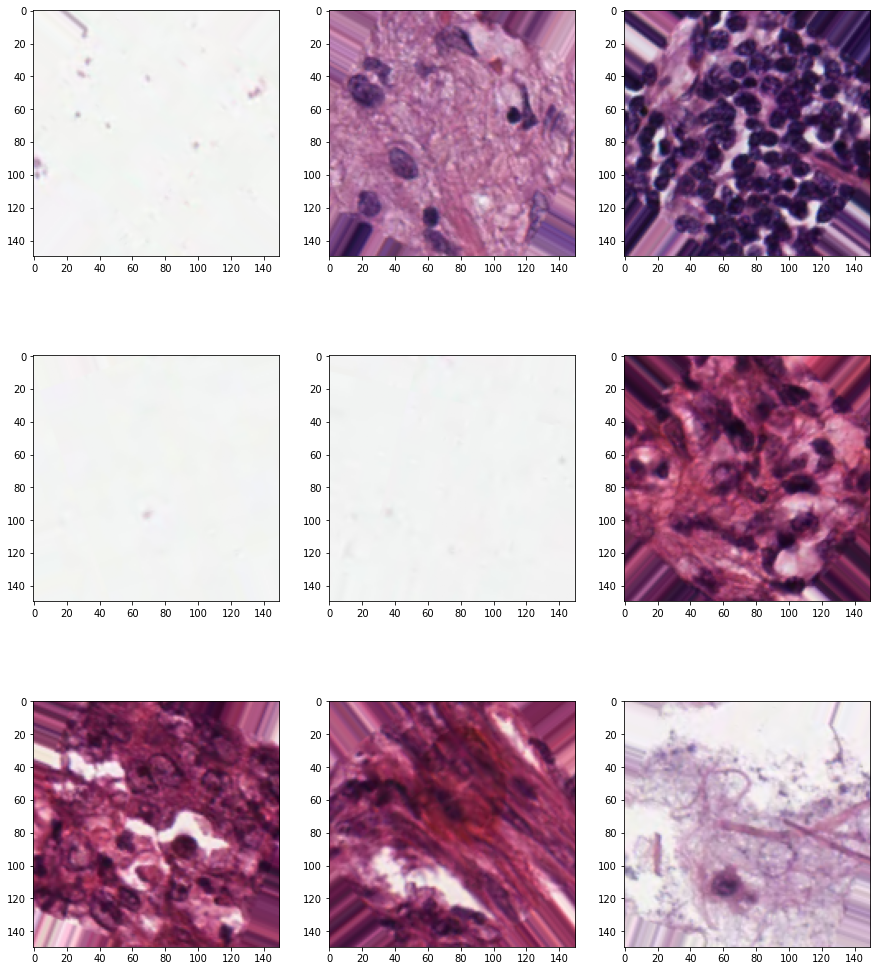

In [63]:
datagen = ImageDataGenerator(rotation_range=90)

# fit parameters from data
datagen.fit(x_train)

# Configure batch size and retrieve one batch of images
plt.subplots(3, 3, figsize = (15, 18))             
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    # show the plot
    plt.show()
    break

### Zoom in images

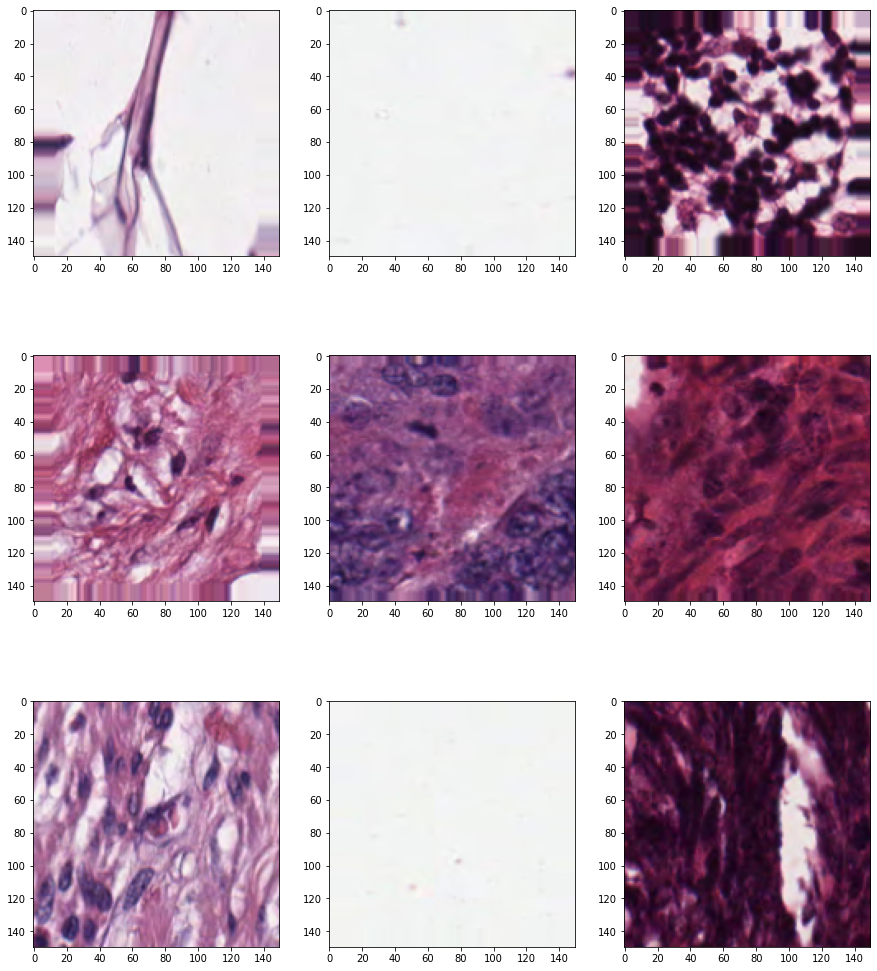

In [64]:
datagen = ImageDataGenerator(zoom_range=0.2)

# fit parameters from data
datagen.fit(x_train)

# Configure batch size and retrieve one batch of images
plt.subplots(3, 3, figsize = (15, 18))             
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    # show the plot
    plt.show()
    break